In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

## VG Plots

In [3]:
def nencioli(u, v, lon, lat, a, b):

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
        min_radial_dist = 3
        # Initialize sublist and index list with the center element
        sublist = [lst[ic]]
        indices = [ic]
        # Move left and check if magnitude increases with tolerance, at least 3 indices
        count_left = 0
        for i in range(ic - 1, -1, -1):
            if count_left < min_radial_dist:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
                count_left += 1
            elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
            else:
                break    
        # Move right and check if magnitude increases with tolerance, at least 3 indices
        count_right = 0
        for i in range(ic + 1, len(lst)):
            if count_right < min_radial_dist:
                sublist.append(lst[i])
                indices.append(i)
                count_right += 1
            elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
                sublist.append(lst[i])
                indices.append(i)
            else:
                break
        return np.array(sublist), indices

    u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        r_squared = 1 - (ss_residuals / ss_total)
        return coefficients, std_err_coeffs, r_squared
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    else:
        xc = yc = np.nan

    return xc, yc, xx, yy


In [207]:
MAX_DISPLACEMENT = 50000
plot_data = {}
for eddy in the_frontier_eddies:
    plot_data[eddy] = {}
    for t in range(30):
        var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
        
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]
        
        a, b = 6, 5
        xcs, ycs, zcs = [], [], []
        flag = 1
        depth_dics = {}
        for depth_lvl in range(U.shape[-1]):
            if flag:
                u = U[:, :, depth_lvl]
                v = V[:, :, depth_lvl]
                X, Y = np.meshgrid(x, y)
                neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)
                
                neddy = neddy[neddy[:, 2] == var]
        
                if len(neddy[:, 1]) > 1:
                    if depth_lvl == 0:
                        R = np.sqrt(neddy[:, 1]**2 + neddy[:, 0]**2)
                    else:
                        R = np.sqrt((xcs[-1]-neddy[:, 1])**2 + (ycs[-1]-neddy[:, 0])**2)
                    neddy = neddy[R == np.nanmin(R)]
                    
                if len(neddy[:, 1]) == 1:
        
                    n_xc, n_yc = neddy[0, 1], neddy[0, 0] 
                    n_ic = np.where(n_xc == x)[0][0]
                    n_jc = np.where(n_yc == y)[0][0]
                    
                    u1 = u[:, n_jc].squeeze()
                    v1 = v[:, n_jc].squeeze()
                
                    u2 = u[n_ic, :].squeeze()
                    v2 = v[n_ic, :].squeeze()
        
                    xc, yc, xx, yy = moca(u1, v1, u2, v2, n_ic, n_jc, dx)
                    if depth_lvl == 0:
                        R = MAX_DISPLACEMENT - 10
                    else:
                        R = np.sqrt((xcs[-1]-(n_xc + xc))**2 + (ycs[-1]-(n_yc + yc))**2)
                    if R <= MAX_DISPLACEMENT:
                        xcs.append(n_xc + xc)
                        ycs.append(n_yc + yc)
                        zcs.append(z_r[150, 150, depth_lvl])
        
                        depth_dics['Depth'+str(depth_lvl)] = {'xc': n_xc + xc, 'yc': n_yc + yc,
                                                             'n_xc': n_xc, 'n_yc': n_yc,
                                                             'Depth': z_r[150, 150, depth_lvl],
                                                             'x': xx, 'y': yy, 'df': pd.DataFrame({'x': xcs, 'y': ycs, 'z': zcs})}
                    else:
                        flag = 0
                else:
                    flag = 0
        plot_data[eddy]['T'+str(t)] = depth_dics

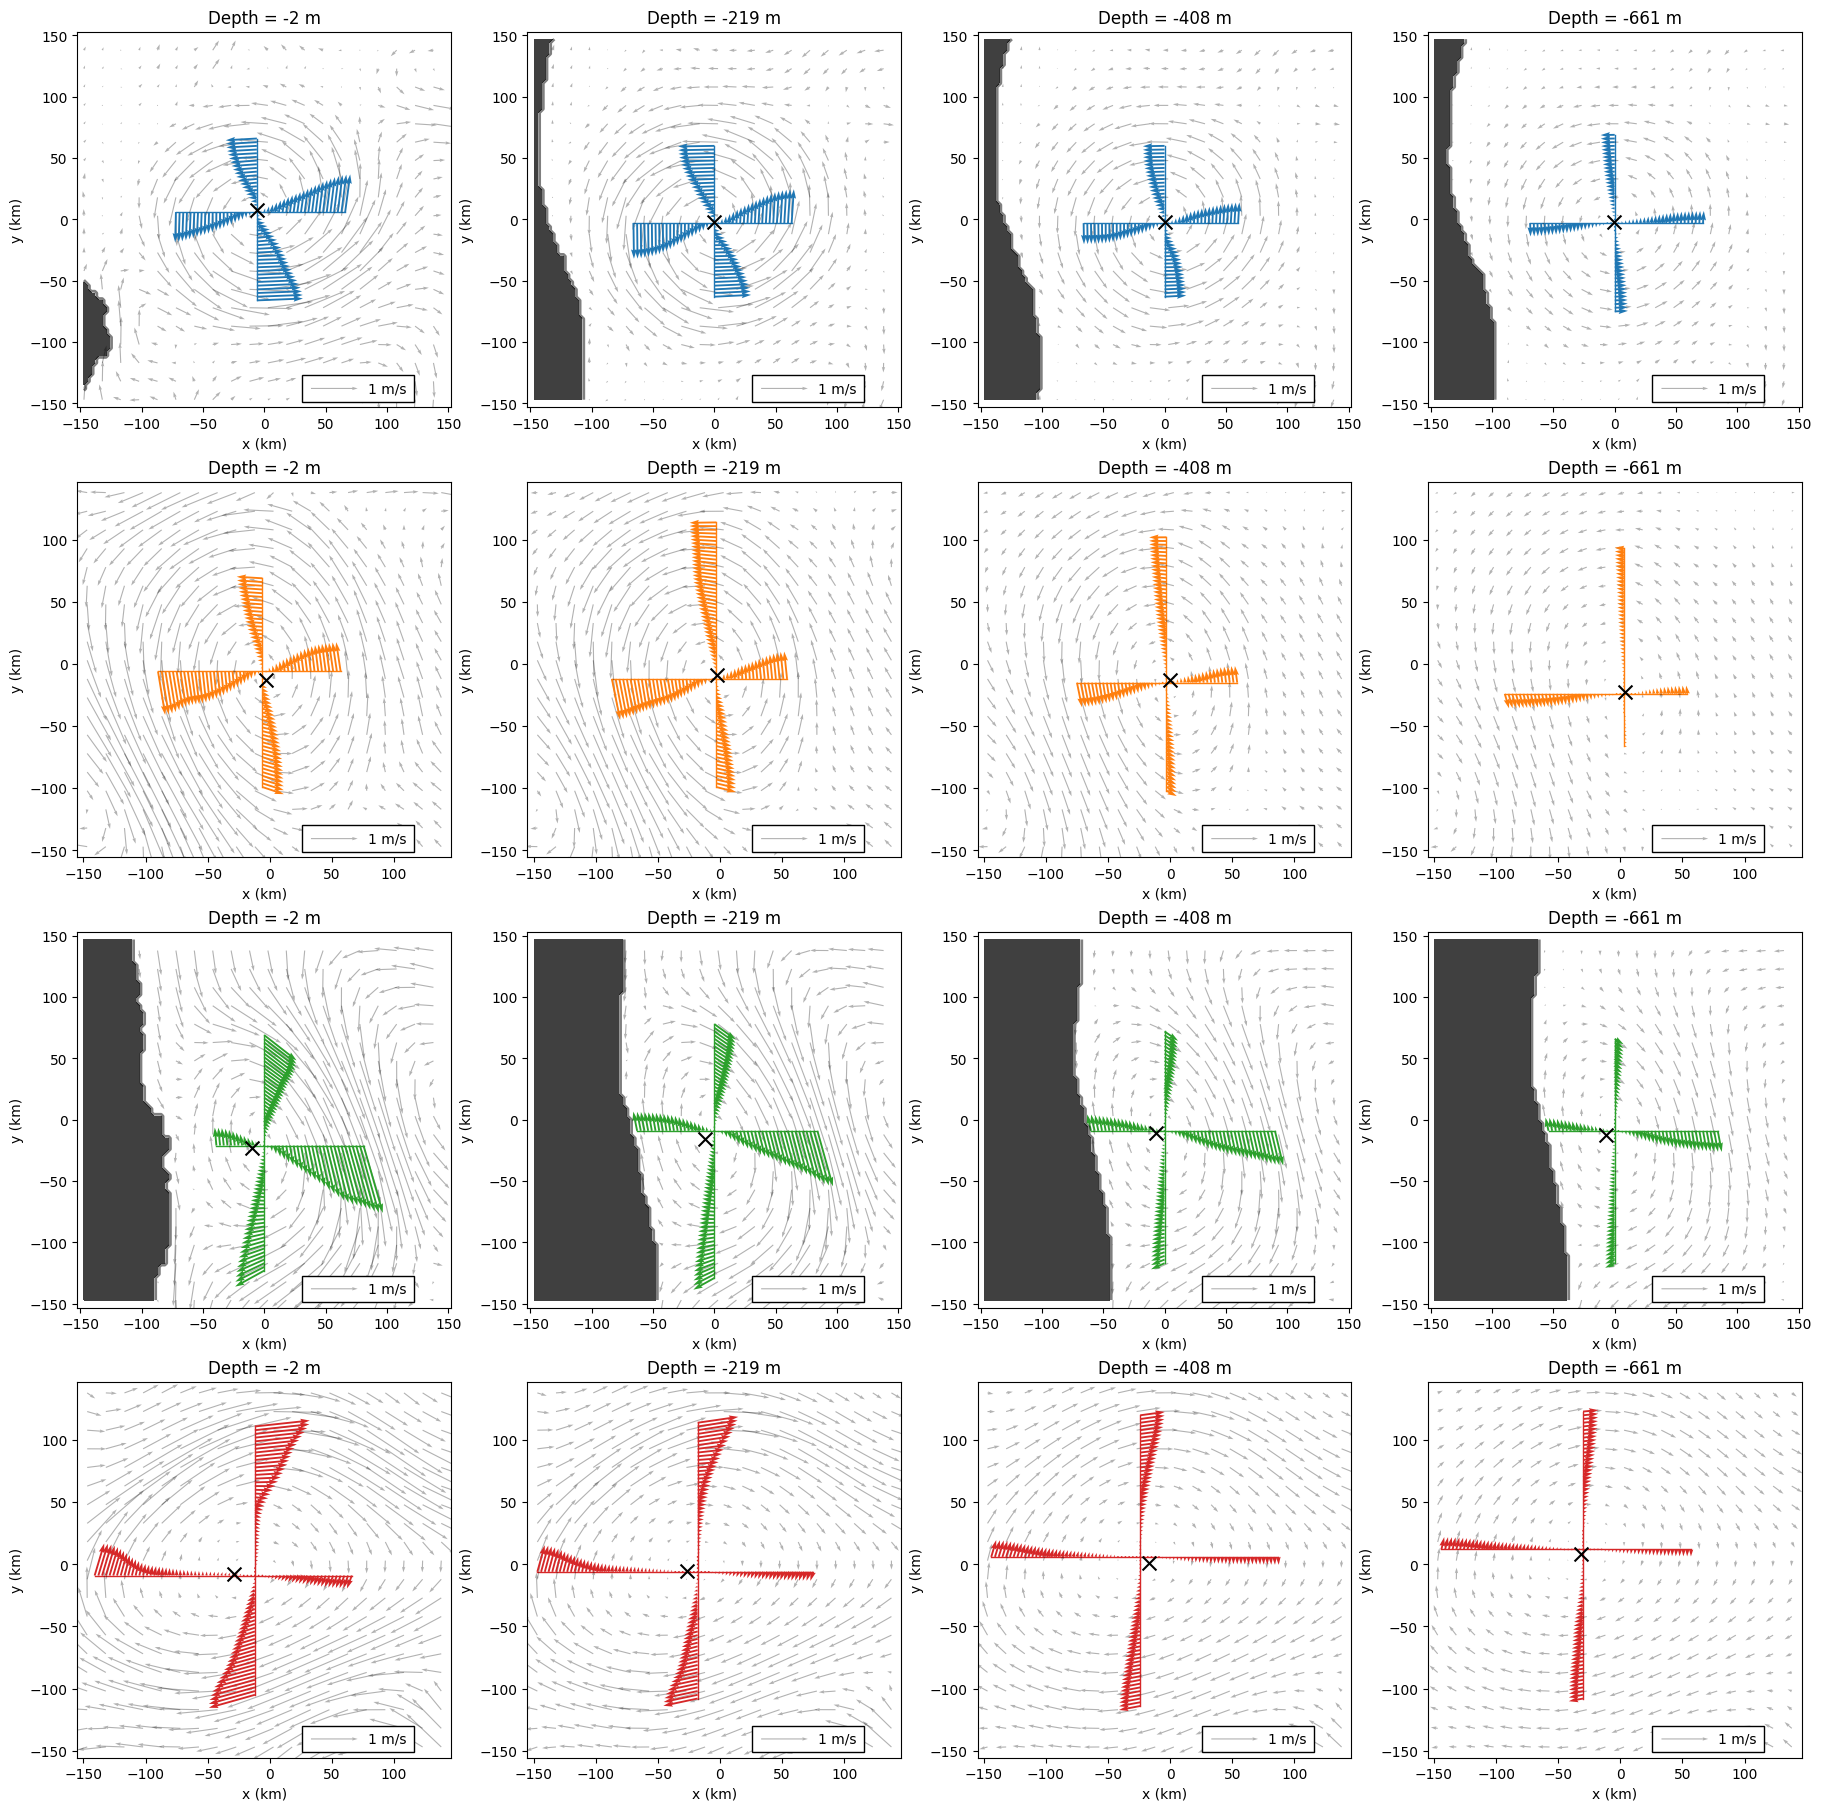

In [241]:
from matplotlib.patches import Rectangle
times = [15, 0, 15, 15]
fig, axes = plt.subplots(4, 4, figsize=(18, 18), constrained_layout=True)#, sharex=True, sharey=True)
for r, eddy in enumerate(the_frontier_eddies):
    
    t = times[r]
    depth_lvls = [0, 15, 18, 20]
    
    scale_factor = [8, 8, 8, 8]
    colors = plt.cm.tab10.colors * 3
    
    for i, depth_lvl in enumerate(depth_lvls):
        ax = axes[r, i]
        
        u = sample_data[eddy]['T' + str(t)]['U'][:, :, depth_lvl]
        v = sample_data[eddy]['T' + str(t)]['V'][:, :, depth_lvl]
        x = sample_data[eddy]['T' + str(t)]['x'] / 1000
        y = sample_data[eddy]['T' + str(t)]['y'] / 1000
        
        X, Y = np.meshgrid(x, y)
        spacing = 5
        quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                  alpha=0.3, scale=scale_factor[i])
        data = plot_data[eddy]['T'+str(t)]
        n_xc = data['Depth' + str(depth_lvl)]['n_xc'] / 1000
        n_yc = data['Depth' + str(depth_lvl)]['n_yc'] / 1000
        xc = data['Depth' + str(depth_lvl)]['xc'] / 1000
        yc = data['Depth' + str(depth_lvl)]['yc'] / 1000
        xx = data['Depth' + str(depth_lvl)]['x'] / 1000
        yy = data['Depth' + str(depth_lvl)]['y'] / 1000
        
        ix = np.where(np.isin(x, xx + n_xc))[0]
        jy = np.where(np.isin(y, yy + n_yc))[0]
        i_nenc = np.where(n_xc == x)[0]
        j_nenc = np.where(n_yc == y)[0]
        iu = u[ix, j_nenc]
        iv = v[ix, j_nenc]
        ju = u[i_nenc, jy]
        jv = v[i_nenc, jy]
        
        spacing = 1
        ax.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
                  iu[::spacing], iv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
                  ju[::spacing], jv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.plot(xx + n_xc, [n_yc] * len(xx), zorder=0, linewidth=1, color=colors[r])
        ax.plot([n_xc] * len(yy), yy + n_yc, zorder=0, linewidth=1, color=colors[r])
        ax.scatter(xc, yc, marker='x', s=100, color='k')
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(f"Depth = {round(z_r[150,150,depth_lvl])} m")

        if np.any(np.isnan(u)) and r != 1:
            nan_mask = np.isnan(u)
            mask = np.where(~np.isnan(u), np.nan, 0)
            ax.contourf(x, y, mask.T, cmap='gray', zorder=-1)
            ax.contour(x, y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

        magnitude = 1
        x_pos, y_pos = 0.75, 0.05  
        box_width = 0.3  # Adjust width as needed
        box_height = 0.07  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                     label=f'{magnitude} m/s', labelpos='E')
        ax.axis('equal')
plt.show()


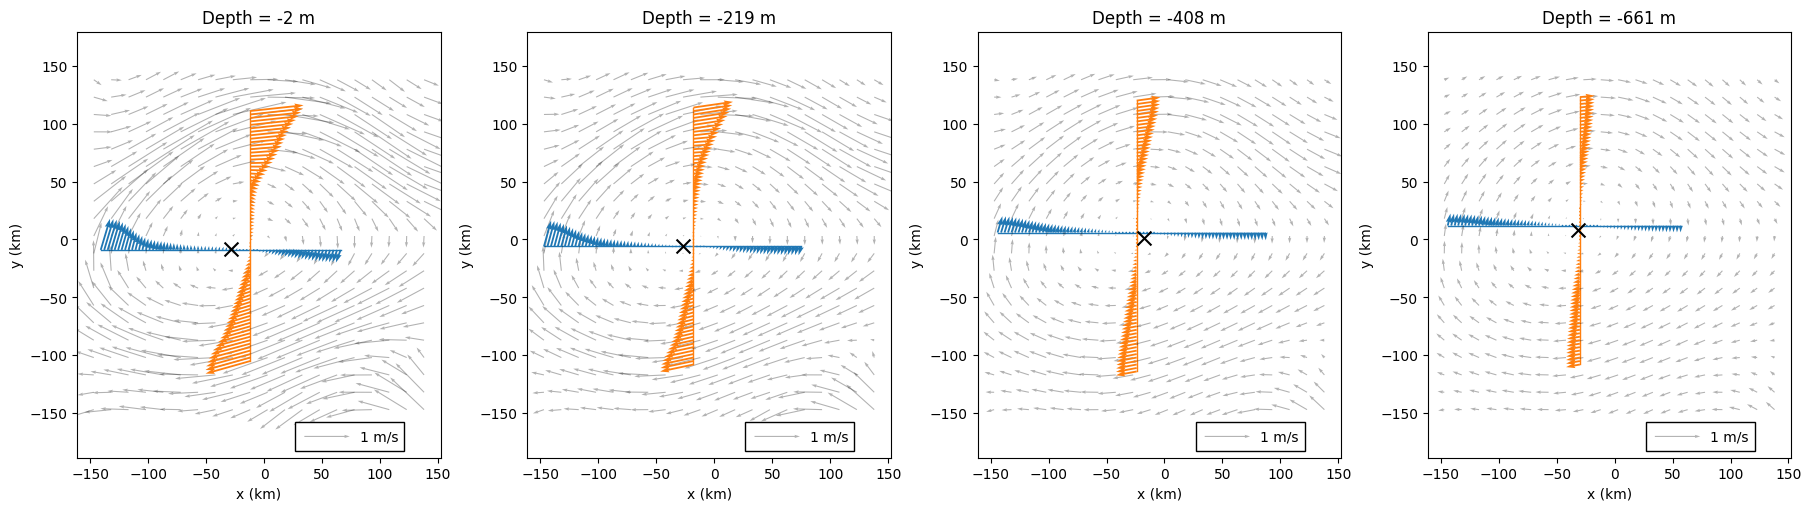

In [214]:
from matplotlib.patches import Rectangle
t = 15
eddy = the_frontier_eddies[3]
fig, axes = plt.subplots(1, 4, figsize=(18, 5), constrained_layout=True)#, sharex=True, sharey=True)

depth_lvls = [0, 15, 18, 20]

scale_factor = [8, 8, 8, 8]
colors = plt.cm.tab10.colors * 3

for i, depth_lvl in enumerate(depth_lvls):
    ax = axes.flat[i]
    
    u = sample_data[eddy]['T' + str(t)]['U'][:, :, depth_lvl]
    v = sample_data[eddy]['T' + str(t)]['V'][:, :, depth_lvl]
    x = sample_data[eddy]['T' + str(t)]['x'] / 1000
    y = sample_data[eddy]['T' + str(t)]['y'] / 1000
    
    X, Y = np.meshgrid(x, y)
    spacing = 5
    quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
              u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
              alpha=0.3, scale=scale_factor[i])
    data = plot_data[eddy]['T'+str(t)]
    n_xc = data['Depth' + str(depth_lvl)]['n_xc'] / 1000
    n_yc = data['Depth' + str(depth_lvl)]['n_yc'] / 1000
    xc = data['Depth' + str(depth_lvl)]['xc'] / 1000
    yc = data['Depth' + str(depth_lvl)]['yc'] / 1000
    xx = data['Depth' + str(depth_lvl)]['x'] / 1000
    yy = data['Depth' + str(depth_lvl)]['y'] / 1000
    
    ix = np.where(np.isin(x, xx + n_xc))[0]
    jy = np.where(np.isin(y, yy + n_yc))[0]
    i_nenc = np.where(n_xc == x)[0]
    j_nenc = np.where(n_yc == y)[0]
    iu = u[ix, j_nenc]
    iv = v[ix, j_nenc]
    ju = u[i_nenc, jy]
    jv = v[i_nenc, jy]
    
    spacing = 1
    ax.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
              iu[::spacing], iv[::spacing], color=colors[0], scale=scale_factor[i], width=0.005)
    ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
              ju[::spacing], jv[::spacing], color=colors[1], scale=scale_factor[i], width=0.005)
    ax.plot(xx + n_xc, [n_yc] * len(xx), zorder=0, linewidth=1)
    ax.plot([n_xc] * len(yy), yy + n_yc, zorder=0, linewidth=1)
    ax.scatter(xc, yc, marker='x', s=100, color='k')
    
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title(f"Depth = {round(z_r[150,150,depth_lvl])} m")

    magnitude = 1
    x_pos, y_pos = 0.75, 0.05  
    box_width = 0.3  # Adjust width as needed
    box_height = 0.07  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2),  # Bottom-left corner
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    
    # Add the quiver key
    ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')
    ax.axis('equal')
plt.show()

Text(0, 0.5, 'y (km)')

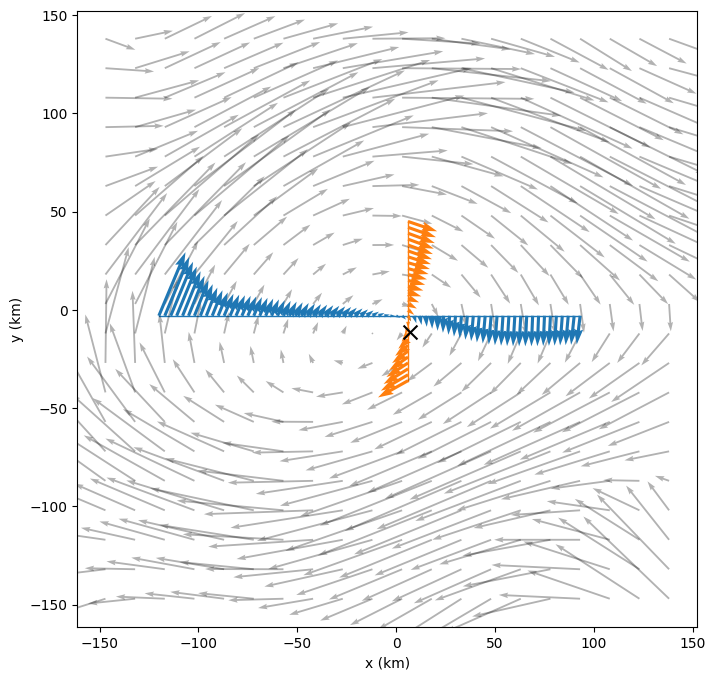

In [211]:
depth_lvl = 10

u = sample_data[eddy]['T'+str(t)]['U'][:,:,depth_lvl]
v = sample_data[eddy]['T'+str(t)]['V'][:,:,depth_lvl]
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
 
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(8,8))
spacing = 5 
scale_factor = 5

plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], 
           u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.3, scale=scale_factor)

n_xc = depth_dics['Depth'+str(depth_lvl)]['n_xc']/1000
n_yc = depth_dics['Depth'+str(depth_lvl)]['n_yc']/1000
xc = depth_dics['Depth'+str(depth_lvl)]['xc']/1000
yc = depth_dics['Depth'+str(depth_lvl)]['yc']/1000
xx = depth_dics['Depth'+str(depth_lvl)]['x']/1000
yy = depth_dics['Depth'+str(depth_lvl)]['y']/1000

ix = np.where(np.isin(x, xx + n_xc))[0]
jy = np.where(np.isin(y, yy + n_yc))[0]
i_nenc = np.where(n_xc==x)[0]
j_nenc = np.where(n_yc==y)[0]
iu = u[ix, j_nenc]
iv = v[ix, j_nenc]
ju = u[i_nenc, jy]
jv = v[i_nenc, jy]
colors = plt.cm.tab10.colors * 3
spacing = 1
plt.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
          iu[::spacing], iv[::spacing], color=colors[0], scale=scale_factor, width=0.005)
plt.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
          ju[::spacing], jv[::spacing], color=colors[1], scale=scale_factor, width=0.005)
plt.plot(xx + n_xc, [n_yc] * len(xx), zorder=0, linewidth=1)
plt.plot([n_xc] * len(yy), yy + n_yc, zorder=0, linewidth=1)
plt.scatter(xc, yc, marker='x', s=100, color='k')

plt.xlabel('x (km)')
plt.ylabel('y (km)')

Text(0.5, 0, 'Depth (m)')

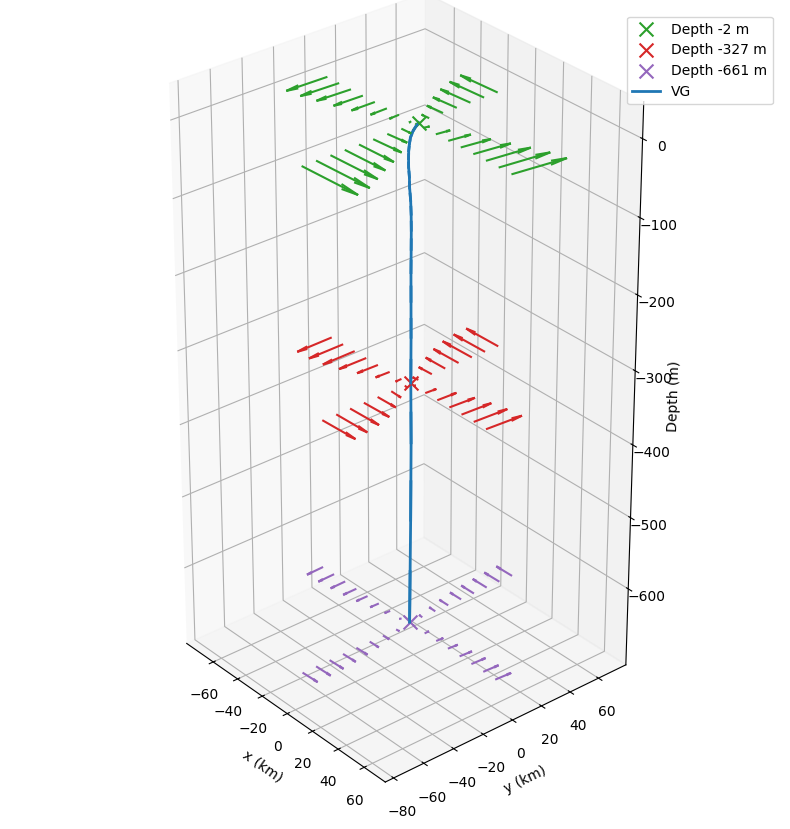

In [115]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x/1000, y/1000)

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000

colors = plt.cm.tab10.colors * 3
i = 1
z_bottom = 21
for depth_dic in depth_dics.values():
    n_xc = depth_dic['n_xc']/1000
    n_yc = depth_dic['n_yc']/1000
    xc = depth_dic['xc']/1000
    yc = depth_dic['yc']/1000
    xx = np.array(depth_dic['x'])/1000
    yy = np.array(depth_dic['y'])/1000
    d_lvl = np.where(depth_dic['Depth']==z_r[150,150,:])[0]

    # if d_lvl in [0,10,14,16,18,19,20]:
    if d_lvl in [0,17, 20]:
        i += 1
        ix = np.where(np.isin(x, xx + n_xc))[0]
        jy = np.where(np.isin(y, yy + n_yc))[0]
        i_nenc = np.where(n_xc==x)[0]
        j_nenc = np.where(n_yc==y)[0]
        iu = U[ix, j_nenc, d_lvl]
        iv = V[ix, j_nenc, d_lvl]
        ju = U[i_nenc, jy, d_lvl]
        jv = V[i_nenc, jy, d_lvl]
        scale_factor = 40
        spacing = 3
        ax.quiver(xx[::spacing]+n_xc, [n_yc] * len(xx[::spacing]), [depth_dic['Depth']] * len(xx[::spacing]),
                  iu[::spacing]*scale_factor, iv[::spacing]*scale_factor, np.zeros_like(iu[::spacing]), color=colors[i])
        ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing]+n_yc, [depth_dic['Depth']] * len(yy[::spacing]),
                  ju[::spacing]*scale_factor, jv[::spacing]*scale_factor, np.zeros_like(ju[::spacing]), color=colors[i])
        ax.scatter(xc, yc, depth_dic['Depth'], marker='x', color=colors[i], s=100, label=f"Depth {round(depth_dic['Depth'])} m")

ax.plot(xcs[:z_bottom]/1000, ycs[:z_bottom]/1000, zcs[:z_bottom], zorder=1, linewidth=2, color=colors[0], label='VG')
for i in range(1, z_bottom):
    x_mid = (xcs[i]+xcs[i-1])/2 / 1000
    y_mid = (ycs[i]+ycs[i-1])/2 / 1000
    z_mid = (zcs[i]+zcs[i-1])/2 
    ax.plot([xcs[i]/1000, x_mid], [ycs[i]/1000, y_mid], [zcs[i], z_mid], linewidth=2, color=colors[0],zorder=10)
    
ax.view_init(elev=30, azim=320) #350
ax.set_box_aspect([1, 1, 2]) 
ax.legend()
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')
